# Проект: классификация

## Постановка задачи:

Банки располагают большими объёмами данных о клиентах, которые можно использовать для персонализированных предложений. Для этого применяется прямой маркетинг — связь с клиентами через разные каналы (лично, по телефону, e-mail, мессенджеры). Однако такие кампании затратны, поэтому важно заранее определять клиентов, которые с наибольшей вероятностью откликнутся на предложение.


## Бизнес-задача: 

определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

## Техническая задача:

построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Цель проекта:

построить модель, которая предскажет откроет ли клиент депозит.



## Датасет: bank_fin.csv  
- 11162 записей  
- 16 признаков + целевая переменная `deposit`  
- Признаки включают: возраст, семейное положение, образование, кредитные обязательства, предыдущие маркетинговые кампании, длительность звонка и др.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
cmap = sns.color_palette("rocket", as_cmap=True)
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
import optuna   

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

`Данные о клиентах банка:`

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды); 
* balance (баланс).


`Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:`

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).


`Прочие признаки:`

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

`Целевая переменная`

 deposit - определяет, согласится ли клиент открыть депозит в банке

In [105]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [107]:
df.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [108]:
from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Маркетинговая кампания банка", explorative=True)
# profile.to_file("bank_report.html")

In [109]:
# profile

В датасете имеется: 
* 25 явных пропусков в признаке баланса
* 70 пропусков в job, закодированных словом unknown
* 497 таких же пропусков в признаке образование
* 7570 значений unknown в признаке poutcome, разберемся с ним позже

In [110]:
# обработка столбца balance: удаление пробелов, знака $, замена запятой на точку, перевод в числовой формат
df['balance'] = (df['balance']
                 .str.replace(r'[\$\s]', '', regex=True)
                 .str.replace(',', '.', regex=False)
                 .astype(float))

In [111]:
# заполнение пропусков в столбце balance медианным значением
df['balance'].fillna(df['balance'].median(), inplace=True)

In [112]:
# Замена "unknown" на модальное значение в job и education
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)
df['education'].replace('unknown', df['education'].mode()[0], inplace=True)

Удалим выбросы в balance и визуализируем до и после удаления

Нижняя граница: -2241.00
Верхняя граница: 4063.00
Число выбросов: 1057
Число оставшихся записей: 10105


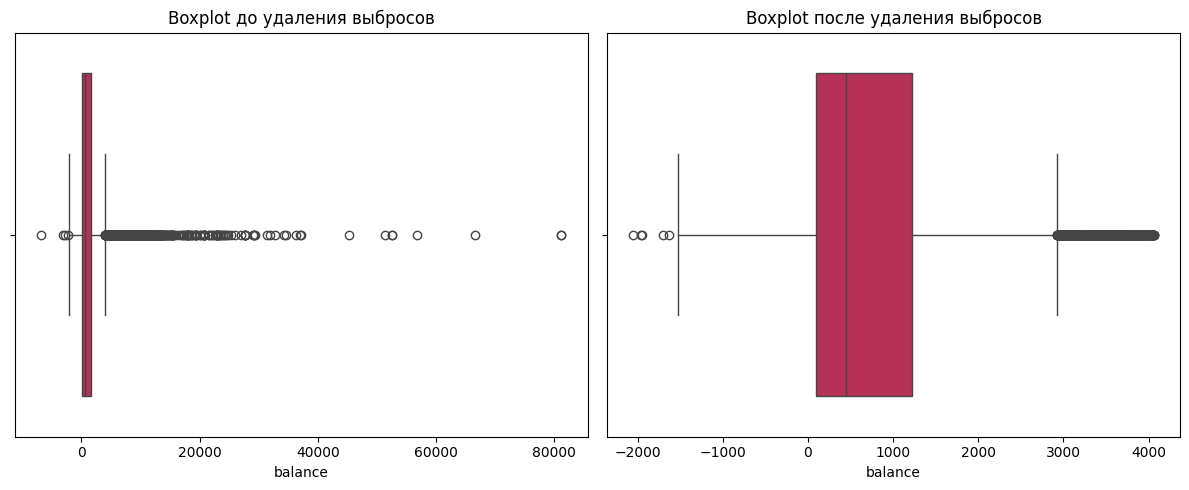

In [113]:
# функция для выявления и удаления выбросов по методу Тьюки (IQR)
def outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]

    quartile_1 = x.quantile(0.25)
    quartile_3 = x.quantile(0.75)
    iqr = quartile_3 - quartile_1

    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]

    return outliers, cleaned, lower_bound, upper_bound

# Визуализация выбросов в признаке balance
plt.figure(figsize=(12,5))

# Boxplot до удаления
plt.subplot(1,2,1)
sns.boxplot(x=df['balance'], palette='rocket')
plt.title("Boxplot до удаления выбросов")

# Очистка от выбросов
outliers, df, lower, upper = outliers_iqr(df, 'balance')

print(f'Нижняя граница: {lower:.2f}')
print(f'Верхняя граница: {upper:.2f}')
print(f'Число выбросов: {outliers.shape[0]}')
print(f'Число оставшихся записей: {df.shape[0]}')

# Boxplot после удаления
plt.subplot(1,2,2)
sns.boxplot(x=df['balance'], palette='rocket')
plt.title("Boxplot после удаления выбросов")

plt.tight_layout()
plt.show()


## Часть 2:  Разведывательный анализ

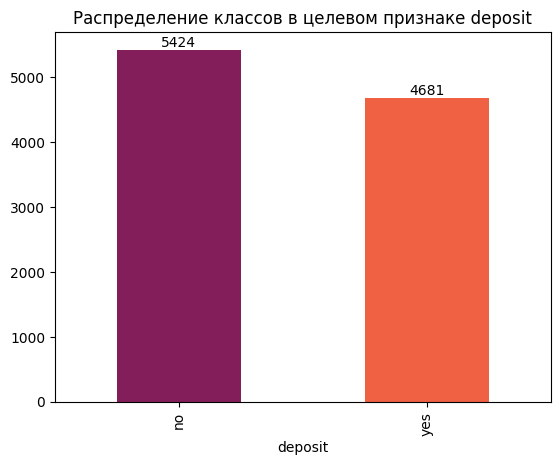

In [114]:
# соотношение классов в данных на предмет несбалансированности, визуализация
colors = sns.color_palette("rocket", 2)

ax = df['deposit'].value_counts().plot(
    kind='bar',
    title='Распределение классов в целевом признаке deposit',
    color=colors
)
# Аннотация значений на столбцах
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),          # текст
        (p.get_x() + p.get_width() / 2., p.get_height()),  # координаты
        ha='center', va='bottom'           # выравнивание
    )

plt.show()

Небольшое смещение ~7%, такой разброс можно считать допустимым

In [115]:
#описательные статистики для количественных переменных
# Количественные признаки
quant_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Описательная статистика
desc_stats = df[quant_features].describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['iqr'] = desc_stats['75%'] - desc_stats['25%']
print("Описательная статистика:\n", desc_stats)

Описательная статистика:
             count        mean         std     min    25%    50%     75%  \
age       10105.0   40.895497   11.734931    18.0   32.0   38.0    48.0   
balance   10105.0  807.653538  994.151966 -2049.0   95.0  445.0  1227.0   
duration  10105.0  368.742603  346.651524     2.0  137.0  252.0   490.0   
campaign  10105.0    2.517170    2.707159     1.0    1.0    2.0     3.0   
pdays     10105.0   51.319644  109.644179    -1.0   -1.0   -1.0     2.0   
previous  10105.0    0.816230    2.243795     0.0    0.0    0.0     1.0   

             max   range     iqr  
age         95.0    77.0    16.0  
balance   4063.0  6112.0  1132.0  
duration  3881.0  3879.0   353.0  
campaign    43.0    42.0     2.0  
pdays      854.0   855.0     3.0  
previous    58.0    58.0     1.0  


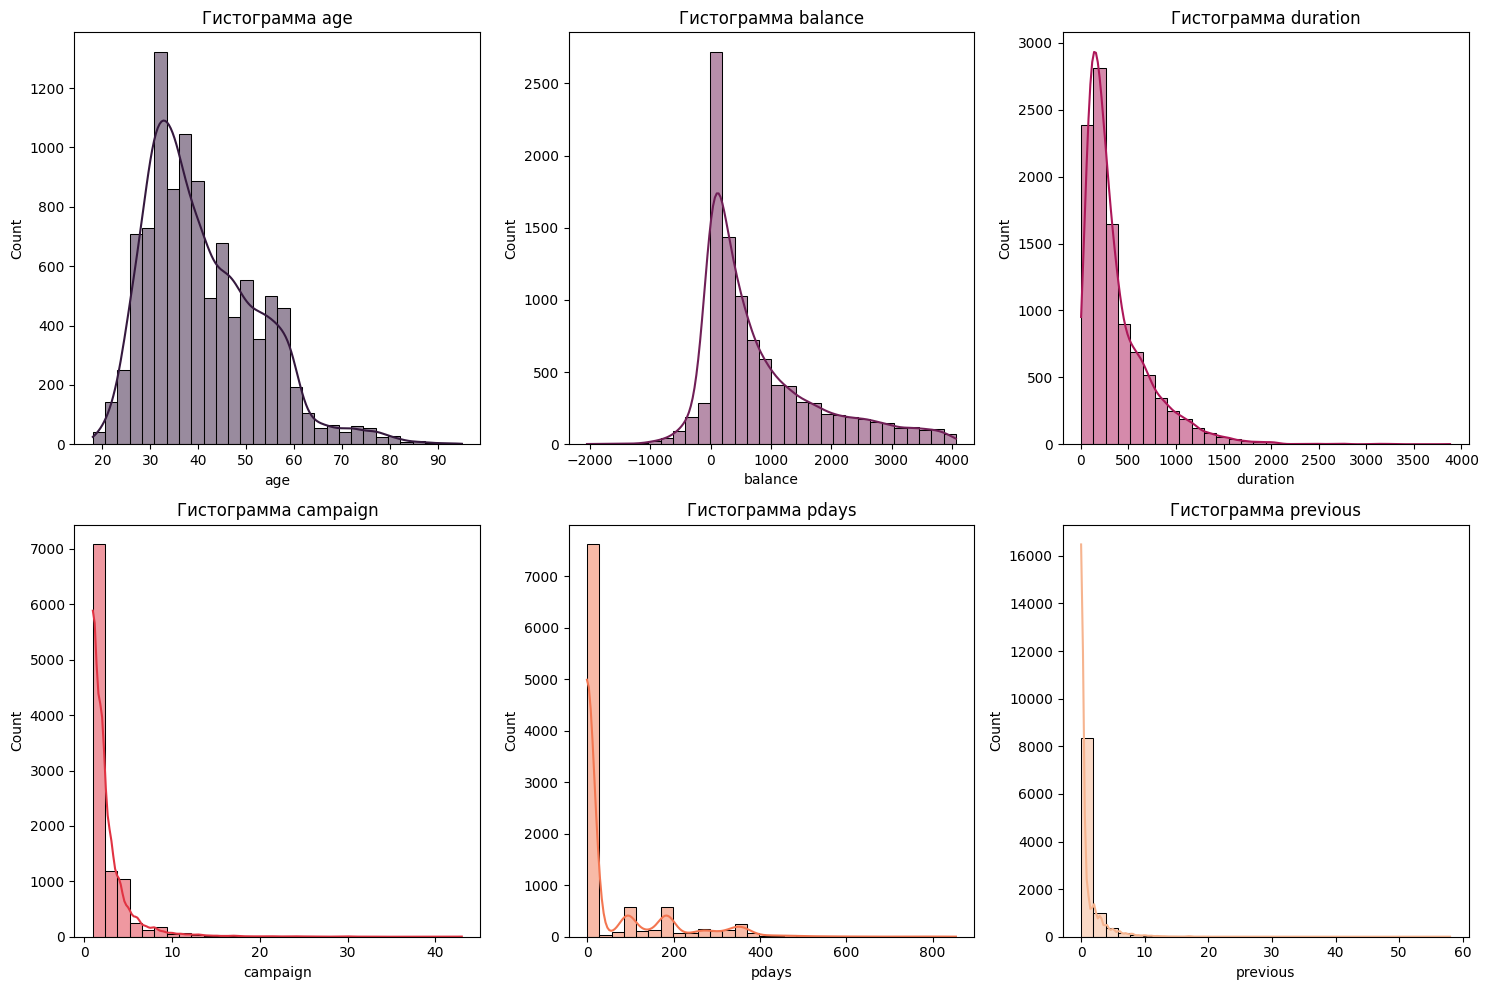

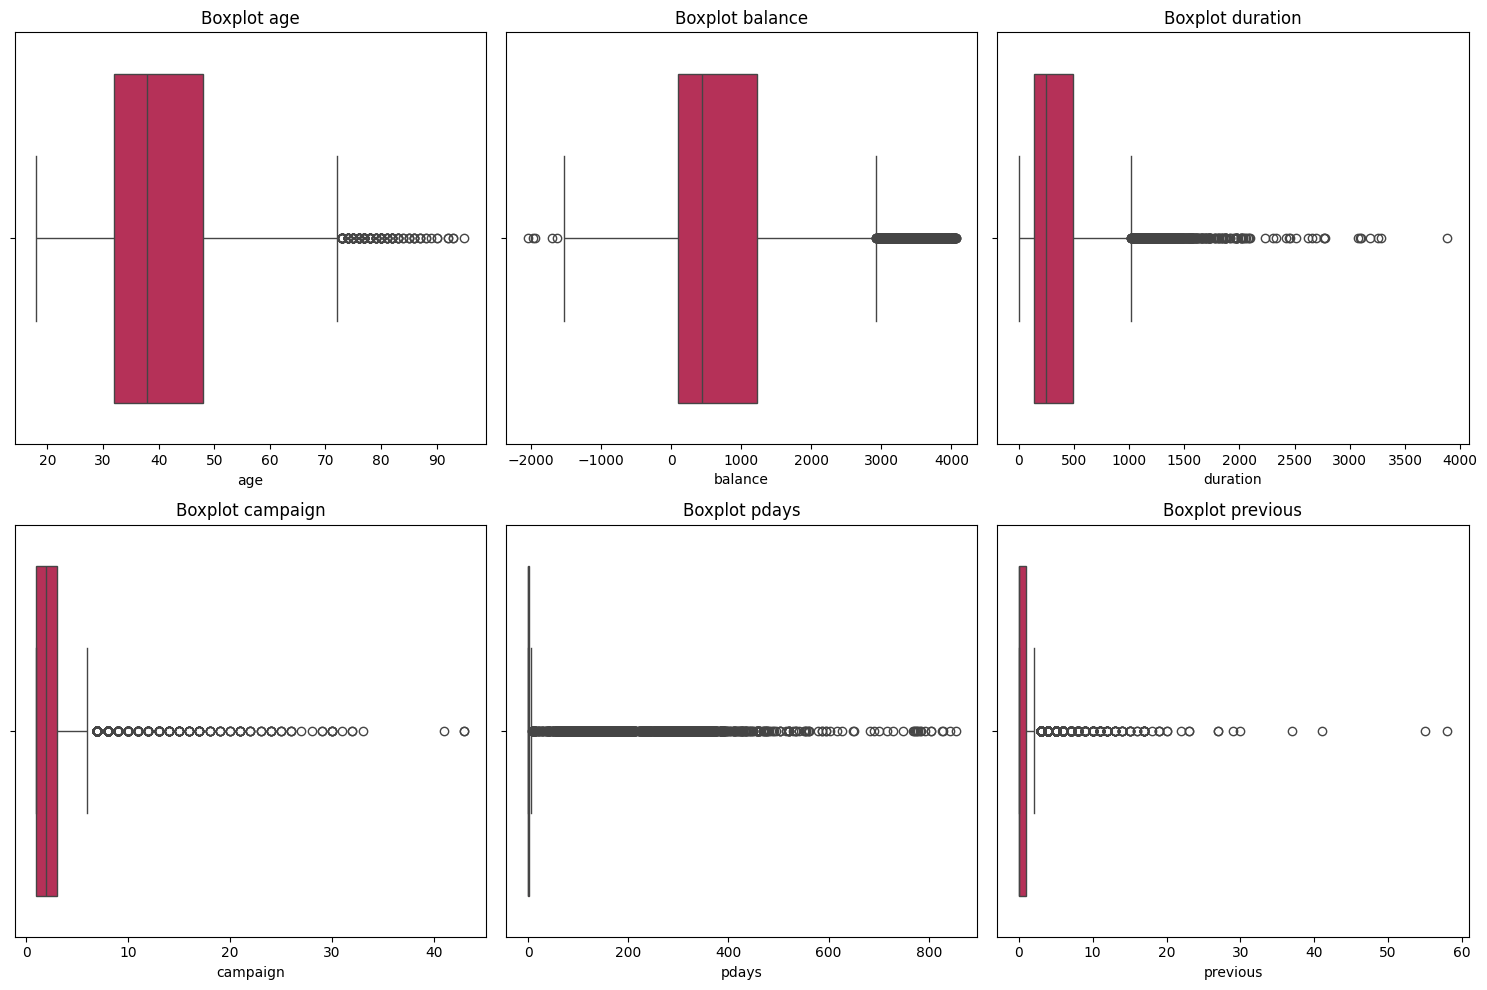

In [116]:
# Визуализация распределений (гистограммы)
plt.figure(figsize=(15,10))
colors = sns.color_palette("rocket", n_colors=len(quant_features))

for i, feature in enumerate(quant_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[feature], bins=30, kde=True, color=colors[i-1])
    plt.title(f'Гистограмма {feature}')
plt.tight_layout()
plt.show()

# Boxplot для выявления выбросов
plt.figure(figsize=(15,10))
for i, feature in enumerate(quant_features, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x=df[feature], palette='rocket')
    plt.title(f'Boxplot {feature}')
plt.tight_layout()
plt.show()

### Анализ количественных признаков

#### 1. Возраст (age)
- **Распределение:** слегка смещено вправо — большинство клиентов молодого и среднего возраста, есть отдельные пожилые клиенты (выбросы справа на boxplot).  
- **Центральная тенденция:** медиана ~38 лет, среднее ~41 год. Среднее чуть выше медианы → наличие пожилых клиентов повышает среднее.  
- **Разброс:** min = 18, max = 95, std ~12 → умеренная вариативность.  
- **Выводы:** выбросы в верхнем диапазоне (пожилые клиенты), распределение близко к нормальному, но с лёгкой правосторонней асимметрией.

#### 2. Баланс (balance)
- **Распределение:** сильно смещено вправо, есть отрицательные балансы (долги).  
- **Центральная тенденция:** медиана ~445, среднее ~808 → среднее выше медианы из-за больших положительных балансов (выбросы).  
- **Разброс:** min = -2049, max = 102127, std ~994 → высокая вариативность.  
- **Выводы:** данные сильно разнятся, есть экстремальные значения, влияющие на среднее. 

#### 3. Продолжительность контакта (duration)
- **Распределение:** сильно смещено вправо — большинство звонков короткие, есть редкие длительные звонки.  
- **Центральная тенденция:** медиана ~252 сек, среднее ~369 сек → длинные звонки повышают среднее.  
- **Разброс:** min = 2, max = 4918, std ~310 → высокая вариативность.  
- **Выводы:** выносные значения справа, логарифмирование поможет при визуализации.

#### 4. Количество контактов (campaign)
- **Распределение:** большинство клиентов контактировали 1–3 раза, редкие случаи — до 43.  
- **Центральная тенденция:** медиана = 2, среднее = 2.76 → редкие частые контакты увеличивают среднее.  
- **Разброс:** min = 1, max = 43, std ~2.7 → вариативность умеренная.  
- **Выводы:** выбросы справа, но в целом большинство клиентов находятся в низком диапазоне.  

#### 5. Пропущенные дни (pdays)
- **Распределение:** много значений -1 (не контактировали в прошлой кампании), редкие положительные значения.  
- **Центральная тенденция:** медиана и среднее близки к -1 → большинство клиентов не контактировалось ранее.  
- **Разброс:** min = -1, max = 871, std ~100 → высокая вариативность из-за редких положительных значений.  
- **Выводы:** распределение сильно скошено, большинство данных сосредоточено на -1

#### 6. Предыдущие контакты (previous)
- **Распределение:** большинство клиентов не контактировали раньше (0), есть редкие случаи до 58.  
- **Центральная тенденция:** медиана = 0, среднее ~0.57 → редкие повторные контакты повышают среднее.  
- **Разброс:** min = 0, max = 58, std ~2.3 → вариативность в целом невысокая, но есть выбросы.  

---


- **Баланс** и **duration** имеют сильные выбросы справа, распределения сильно скошены.  
- **Campaign**, **pdays**, **previous** имеют редкие экстремальные значения, большинство клиентов — в низких диапазонах.  
- **Age** распределён более равномерно, выбросы — только пожилые клиенты.  
- Для признаков с сильной асимметрией полезно использовать **логарифмирование** при визуализации и моделировании.  
- Клиенты с высокими балансами могут чаще иметь длительные контакты или большие campaign (нужно проверить корреляцию).  
- Молодые и средние клиенты составляют большинство, старшие клиенты — редкость, но могут иметь больший баланс.  
- Большинство клиентов не контактировалось в прошлой кампании (pdays = -1) и не имело предыдущих контактов, что важно учитывать при моделировании отклика.  


#### Описательные статистики

In [117]:
# Описательные статистики для категориальных переменных
# Выбираем категориальные признаки
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                'contact', 'month', 'poutcome', 'deposit']

# Рассчёт описательных статистик для категориальных признаков
cat_stats = df[cat_features].describe()
display(cat_stats)


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


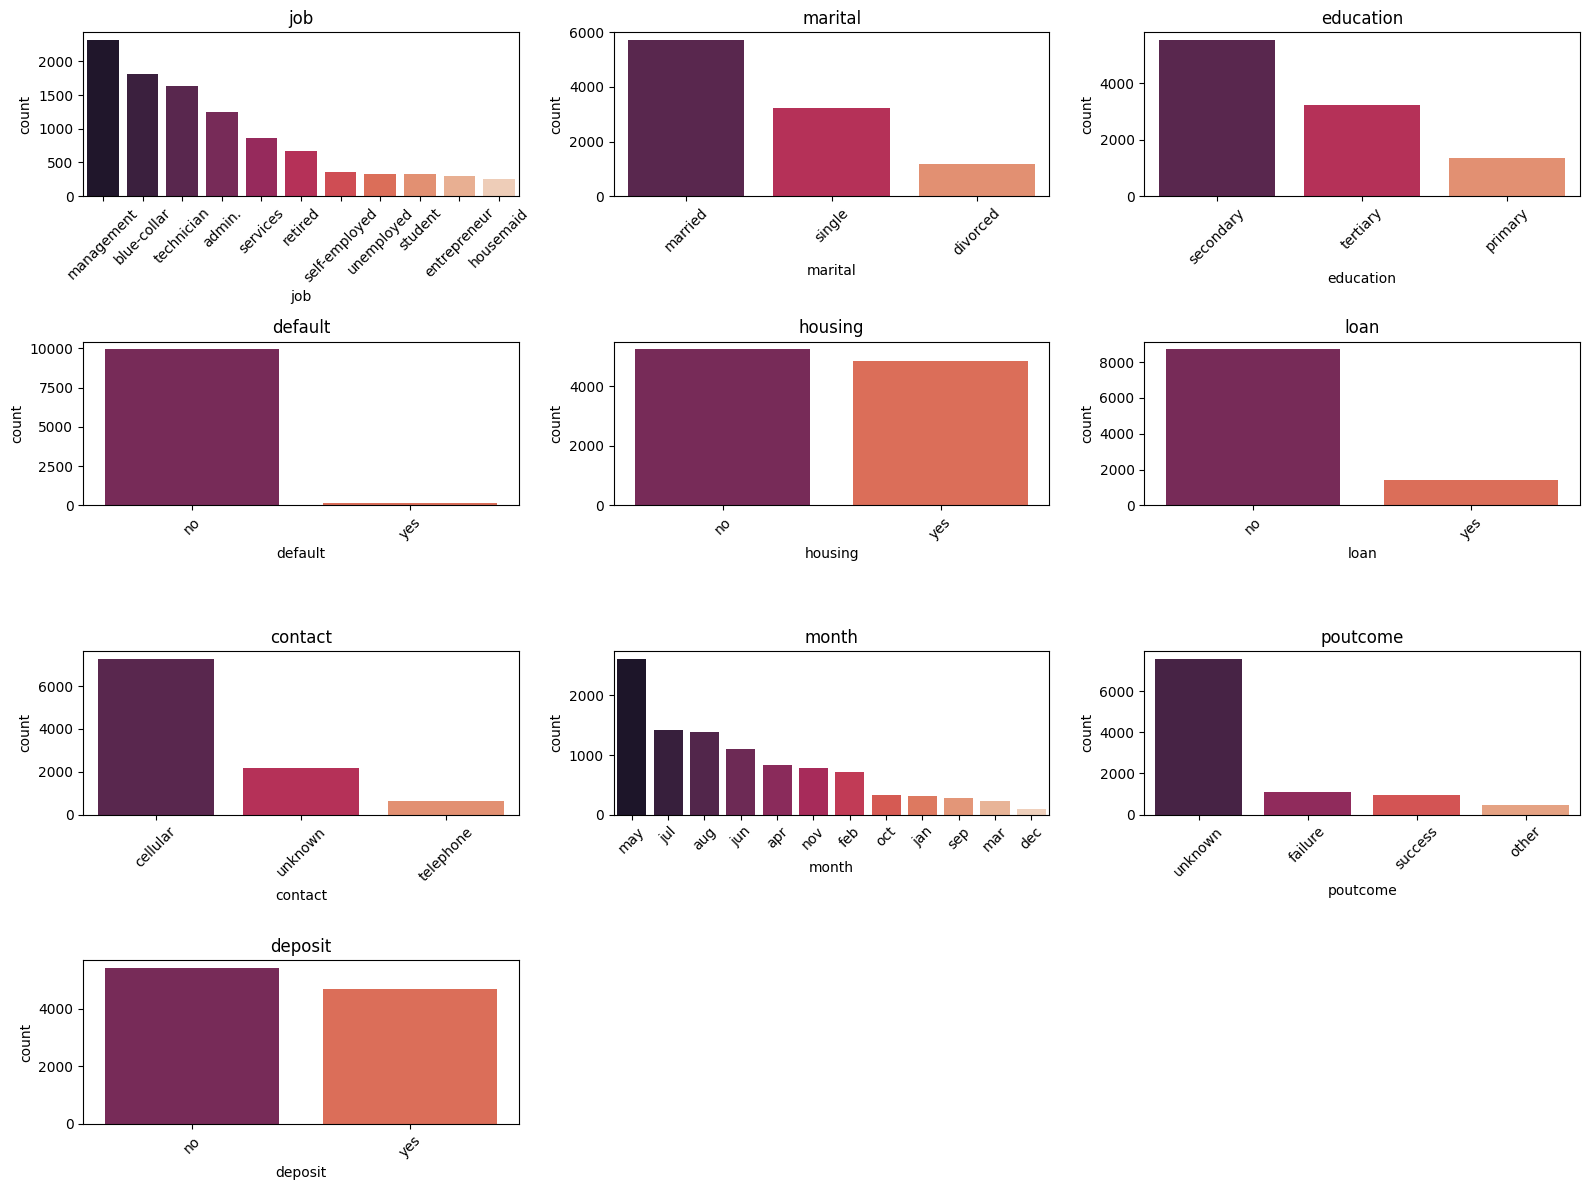

In [118]:
plt.figure(figsize=(16,12))

for i, col in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    sns.countplot(x=df[col], order=df[col].value_counts().index, palette='rocket')
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Большинство клиентов женаты (`married`), имеют среднее образование (`secondary`) и работают в управлении (`management`).  
- Почти все не имеют кредитов по умолчанию (`default=no`), большинство не имеют личного или ипотечного кредита (`loan=no`, `housing=no`).  
- Основной канал связи — мобильный телефон (`cellular`), большинство контактов в мае.  
- Для большинства клиентов нет данных о предыдущей кампании (`poutcome=unknown`).  
- Целевая переменная `deposit` имеет небольшое смещение ~7%, такой разброс можно считать допустимым

In [119]:
# Считаем, где по предыдущей кампании (poutcome) успешных депозитов (yes) больше, чем неудачных (no)
# Группируем по poutcome и считаем количество значений deposit
grouped = df.groupby('poutcome')['deposit'].value_counts()
print(grouped)

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64


Месяц с наибольшим процентом отказов: may


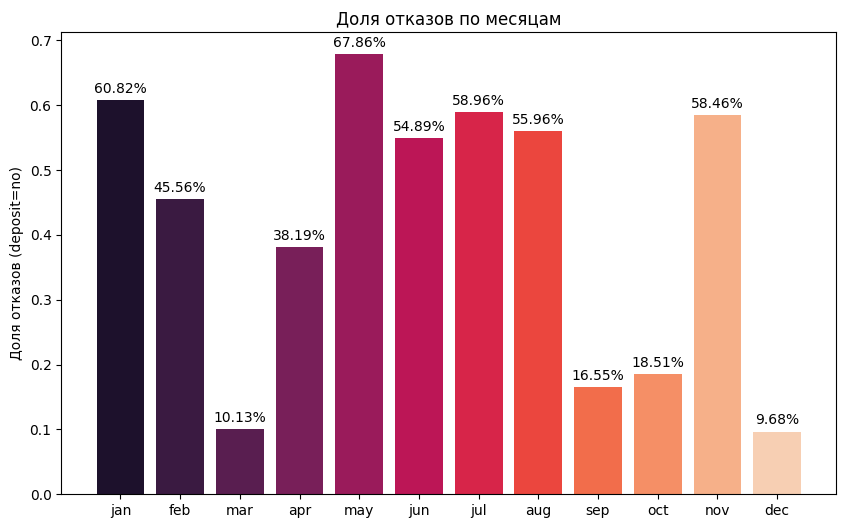

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Список уникальных месяцев в данных
months = df['month'].unique()

# Словарь для хранения доли отказов по каждому месяцу
fail_ratio = {}

for month in months:
    total = df[df['month']==month].shape[0]          # Всего контактов в месяце
    fails = df[(df['month']==month) & (df['deposit']=='no')].shape[0]  # Отказы
    fail_ratio[month] = fails / total               # Отношение отказов к общему числу

# Находим месяц с максимальным отношением отказов
worst_month = max(fail_ratio, key=fail_ratio.get)
print("Месяц с наибольшим процентом отказов:", worst_month)

# Сортировка месяцев по календарю
calendar_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
fail_ratio_sorted = {month: fail_ratio[month] for month in calendar_order if month in fail_ratio}

# Генерируем цвета по палитре rocket в соответствии с количеством столбцов
colors = sns.color_palette("rocket", n_colors=len(fail_ratio_sorted))

# Строим график
plt.figure(figsize=(10,6))
bars = plt.bar(fail_ratio_sorted.keys(), fail_ratio_sorted.values(), color=colors)

plt.ylabel('Доля отказов (deposit=no)')
plt.title('Доля отказов по месяцам')

# Добавляем аннотации над столбцами
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()


Больше отказов от депозита в мае, январе и июле(67.86%, 60.82% и 58.96% соответственно)

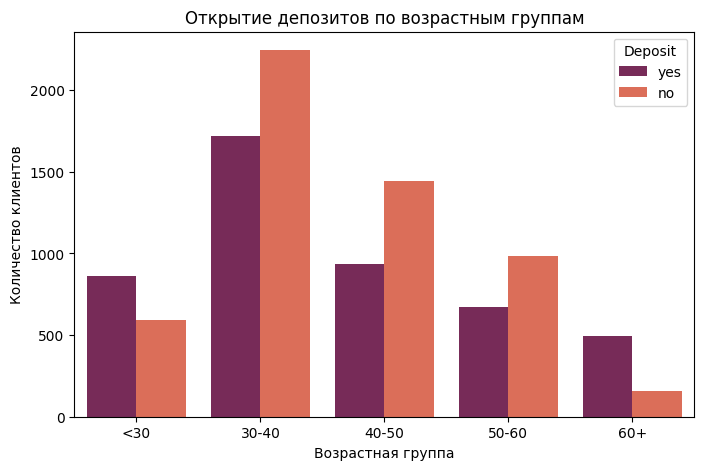

In [121]:
# создаем возрастные группы и определяем, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Создание новой колонки с возрастными группами
bins = [0, 30, 40, 50, 60, 120]  # границы групп
labels = ['<30', '30-40', '40-50', '50-60', '60+']  # подписи
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='age_group', hue='deposit', palette='rocket')
plt.title('Открытие депозитов по возрастным группам')
plt.ylabel('Количество клиентов')
plt.xlabel('Возрастная группа')
plt.legend(title='Deposit')
plt.show()


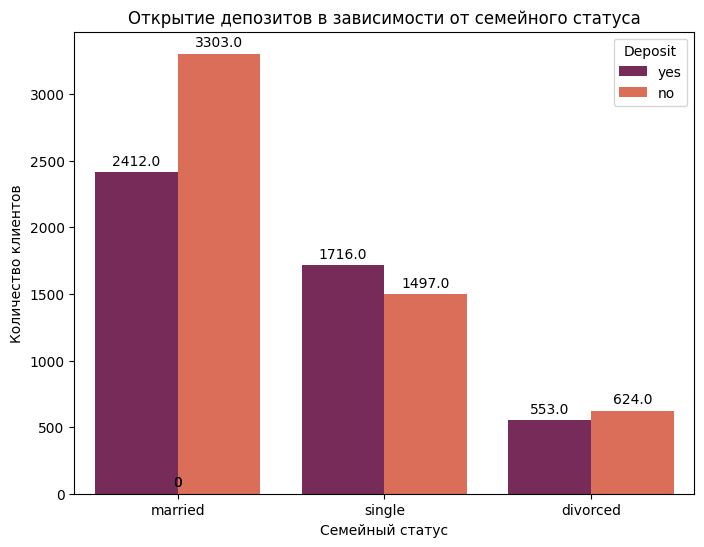

In [122]:
# визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure(figsize=(8,6))
bars = sns.countplot(data=df, x='marital', hue='deposit', palette='rocket')

plt.title('Открытие депозитов в зависимости от семейного статуса')
plt.xlabel('Семейный статус')
plt.ylabel('Количество клиентов')
plt.legend(title='Deposit')

# Добавляем аннотации над столбцами
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height}', 
                  xy=(p.get_x() + p.get_width()/2, height), 
                  xytext=(0,3), 
                  textcoords='offset points', 
                  ha='center', va='bottom')

plt.show()

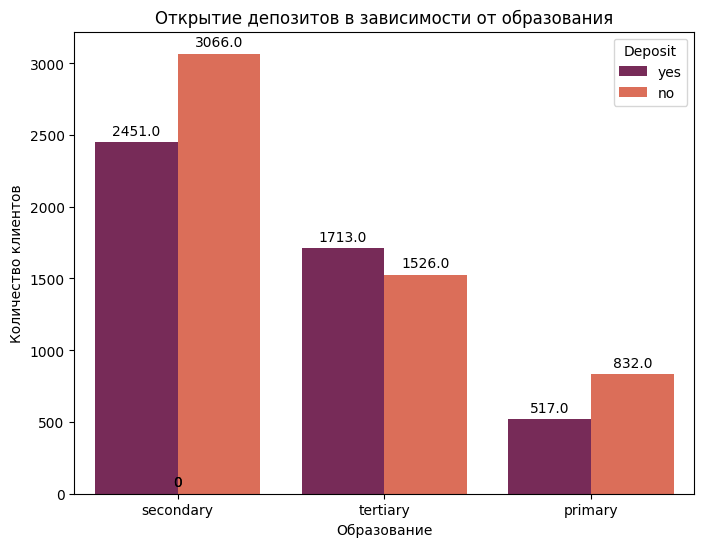

In [123]:
# визуализации для открывших и неоткрывших депозит в зависимости от образования
plt.figure(figsize=(8,6))
bars = sns.countplot(data=df, x='education', hue='deposit', palette='rocket')

plt.title('Открытие депозитов в зависимости от образования')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')
plt.legend(title='Deposit')

# Добавляем аннотации над столбцами
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height}', 
                  xy=(p.get_x() + p.get_width()/2, height), 
                  xytext=(0,3), 
                  textcoords='offset points', 
                  ha='center', va='bottom')

plt.show()

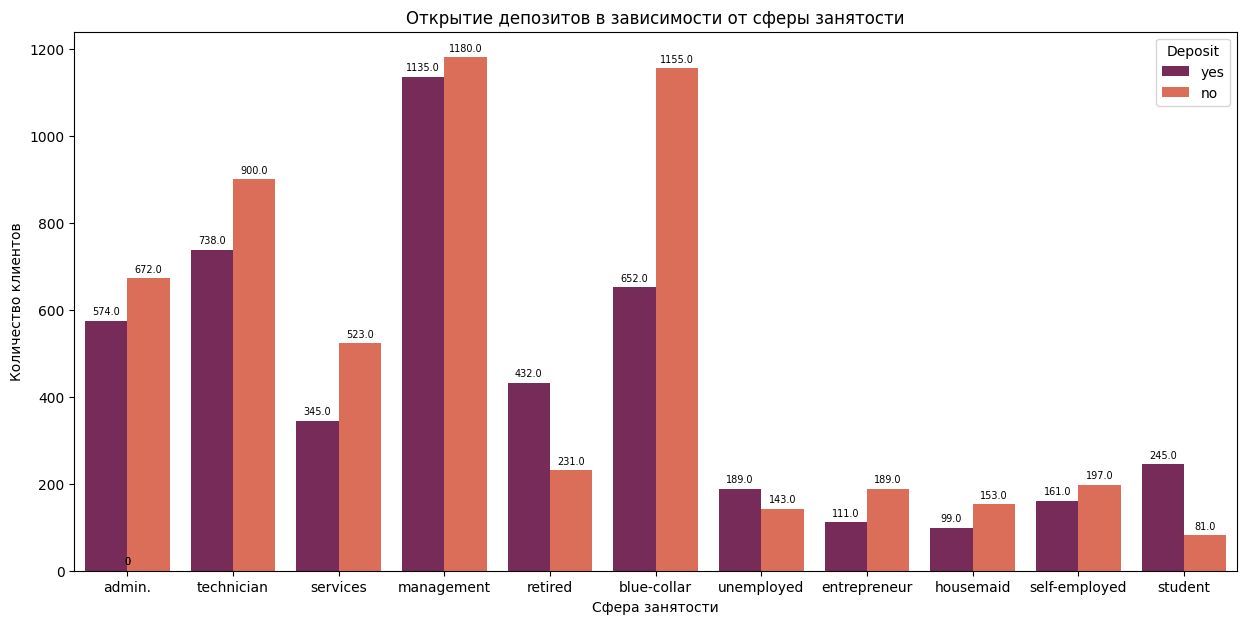

In [124]:
# визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(15,7))
bars = sns.countplot(data=df, x='job', hue='deposit', palette='rocket')

plt.title('Открытие депозитов в зависимости от сферы занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество клиентов')
plt.legend(title='Deposit')

# Добавляем аннотации над столбцами
for p in bars.patches:
    height = p.get_height()
    bars.annotate(f'{height}', 
                  xy=(p.get_x() + p.get_width()/2, height), 
                  xytext=(0,3), 
                  textcoords='offset points', 
                  ha='center', va='bottom',
                  fontsize=7)

plt.show()

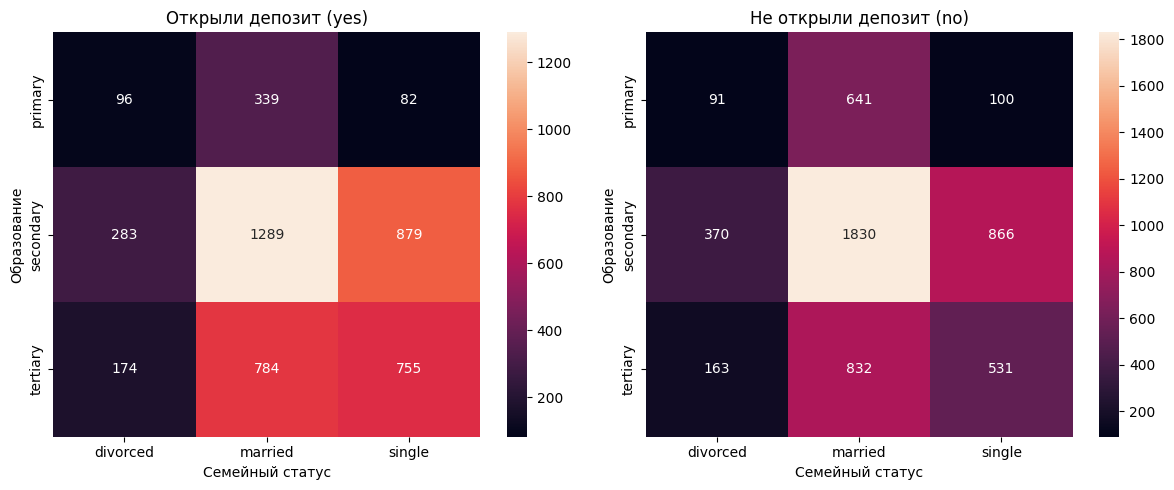

In [125]:
# сводная таблица, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# Данные для открывших депозит
df_yes = df[df['deposit'] == 'yes']

# Данные для не открывших депозит
df_no = df[df['deposit'] == 'no']

# Для открывших депозит
pivot_yes = df_yes.pivot_table(index='education', columns='marital', 
                               aggfunc='size', fill_value=0)

# Для не открывших депозит
pivot_no = df_no.pivot_table(index='education', columns='marital', 
                             aggfunc='size', fill_value=0)

plt.figure(figsize=(12,5))

# Тепловая карта для открывших депозит
plt.subplot(1,2,1)
sns.heatmap(pivot_yes, annot=True, fmt='d', cmap='rocket')
plt.title('Открыли депозит (yes)')
plt.xlabel('Семейный статус')
plt.ylabel('Образование')

# Тепловая карта для не открывших депозит
plt.subplot(1,2,2)
sns.heatmap(pivot_no, annot=True, fmt='d', cmap='rocket')
plt.title('Не открыли депозит (no)')
plt.xlabel('Семейный статус')
plt.ylabel('Образование')

plt.tight_layout()
plt.show()

### Итоги анализа данных
- Наиболее важные категориальные признаки: `marital`, `education`, `housing`, `loan`, `poutcome`.
- Количественные признаки варьируются сильно, есть выбросы по `balance` и `duration`.
- Доля целевого класса (`deposit`): **no – 54.5%**, **yes – 45.5%** → классы почти сбалансированы.


## Часть 3: Преобразование данных

In [126]:
for column in df.select_dtypes(include=['object']).columns:
    print(df[column].value_counts(), '\n')

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64 

marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64 

education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64 

default
no     9939
yes     166
Name: count, dtype: int64 

housing
no     5243
yes    4862
Name: count, dtype: int64 

loan
no     8712
yes    1393
Name: count, dtype: int64 

contact
cellular     7283
unknown      2161
telephone     661
Name: count, dtype: int64 

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64 

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64 

d

In [127]:
# кодирование уровней образования
encoder = LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])

# Кодирование возраста
df['age_group'] = encoder.fit_transform(df['age_group'])
df = df.drop(columns=['age'])

In [128]:
# преобразование бинарных переменных
columns_to_encode = ['default', 'housing', 'loan', 'deposit']
for col in columns_to_encode:
    df[col] = df[col].map({'yes': 1, 'no': 0})



In [129]:
# преобразование номинальных переменных с несколькими различными значениями
columns=['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=columns)

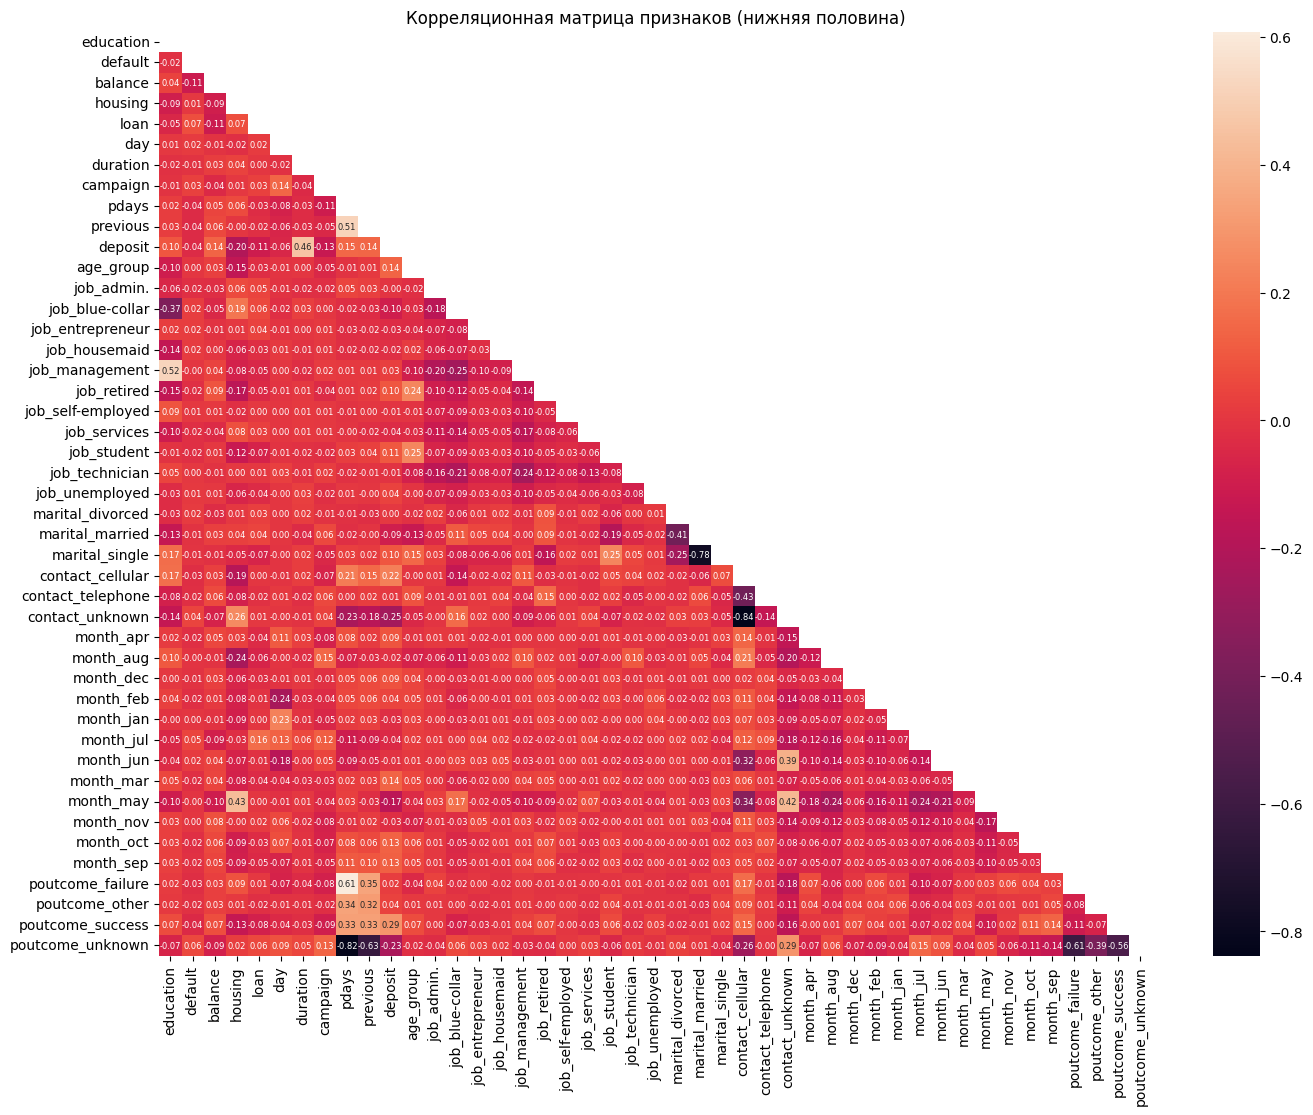

In [130]:
# корреляционная матрица

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) 

plt.figure(figsize=(16,12))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap, annot_kws={"size":6})
plt.title('Корреляционная матрица признаков (нижняя половина)')
plt.show()

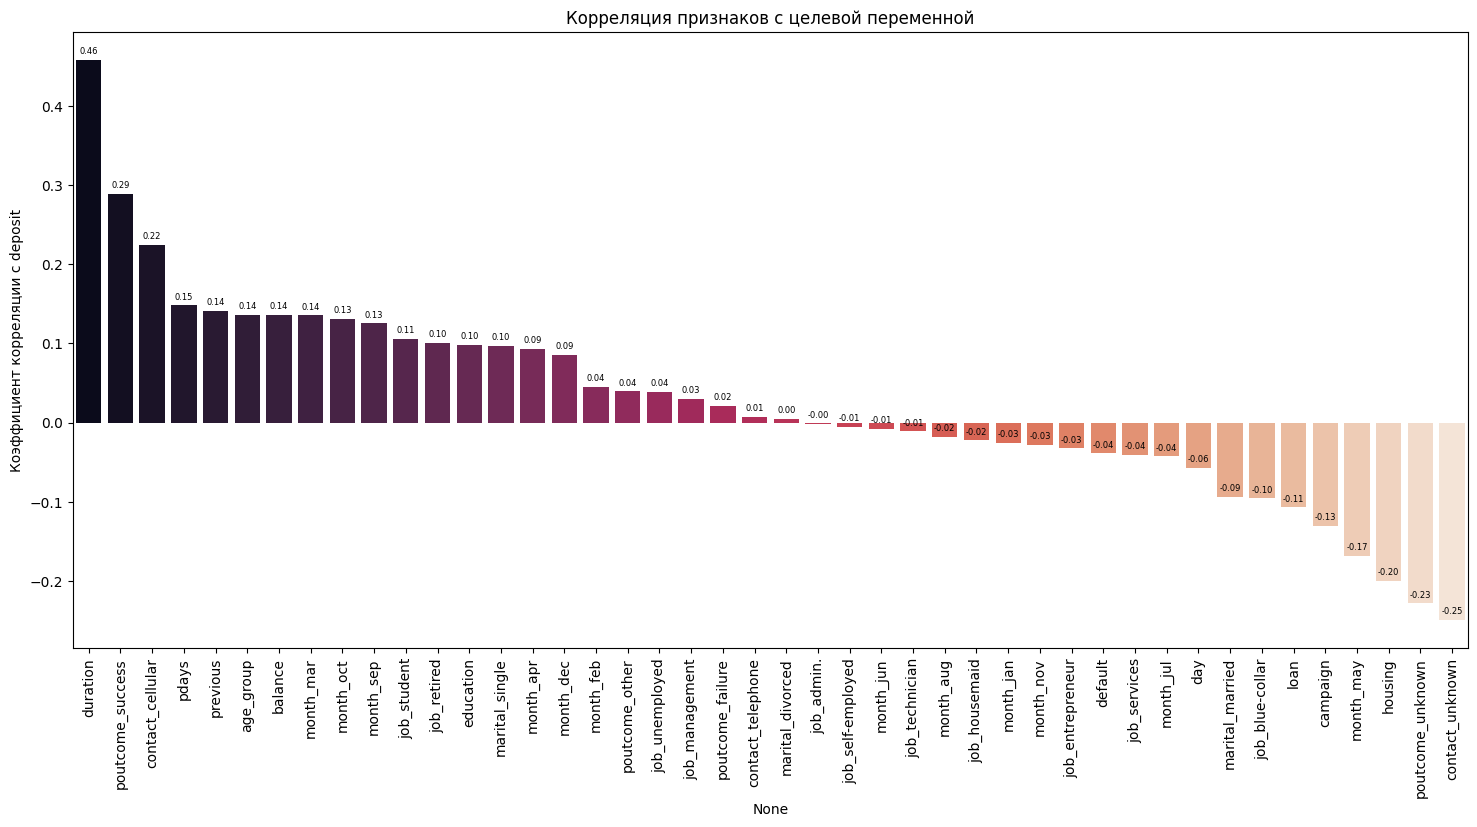

In [131]:
corr_target = df.corr()['deposit'].drop('deposit').sort_values(ascending=False)

# Строим столбчатую диаграмму
plt.figure(figsize=(18,8))
bars = sns.barplot(x=corr_target.index, y=corr_target.values, palette='rocket')
plt.xticks(rotation=90)
plt.ylabel("Коэффициент корреляции с deposit")
plt.title("Корреляция признаков с целевой переменной")

# аннотации
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}', 
                  xy=(bar.get_x() + bar.get_width() / 2, height), 
                  xytext=(0,3), 
                  textcoords="offset points", 
                  ha='center', va='bottom', fontsize=6)

plt.show()

In [132]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [133]:
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (6770, 44)
Размер тестовой выборки: (3335, 44)


### C помощью SelectKBest отберем 15 наиболее подходящих признаков

In [134]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selected_features = X_train.columns[selector.get_support()]
print("Выбранные признаки:", list(selected_features))

Выбранные признаки: ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']



Оставим 15 наиболее значимых числовых признаков (отбор по f_classif).  
Это позволяет снизить размерность и уменьшить риск переобучения.


In [135]:
# Оставляем только выбранные признаки
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [136]:
# Нормализация minmaxscaler

scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Логистическая регрессия


In [137]:
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Решающие деревья

In [138]:
dec_tree = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')
dec_tree.fit(X_train_scaled, y_train)
y_pred_tree = dec_tree.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [139]:
# подбор оптимальных параметров с помощью gridsearch

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
    }

grid_search = GridSearchCV(
    estimator=dec_tree,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
    )

grid_search.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             scoring='f1')

In [140]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}


In [141]:
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [142]:
# случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42)

rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)  
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [143]:
# градиентный бустинг для сравнения качества со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Стекинг

In [144]:
estimators = [
    ('log_reg', log_reg),
    ('dec_tree', dec_tree),
    ('gb', gb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=log_reg)

stacking_clf.fit(X_train_scaled, y_train)
y_pred_stack = stacking_clf.predict(X_test_scaled) 
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [145]:
# признаки, демонстрирующие наибольшую важность в модели градиентного бустинга

selected_features = selector.get_support(indices=True)
feature_names = X.columns[selected_features]
importances = gb.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Топ-5 признаков по важности:")
print(feature_importances.head(5))


Топ-5 признаков по важности:
             Feature  Importance
2           duration    0.501987
13  poutcome_success    0.116264
8    contact_unknown    0.073760
0            balance    0.059764
4              pdays    0.055702


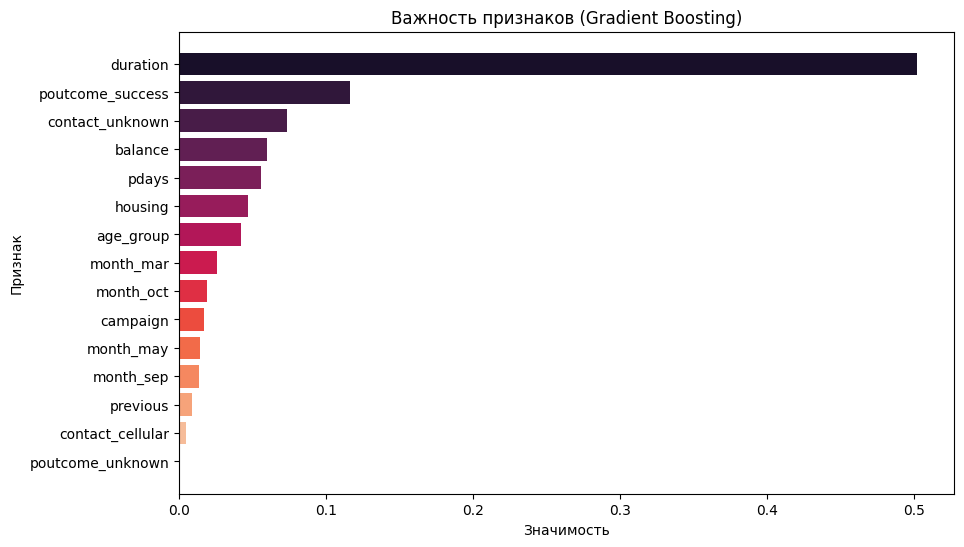

In [146]:
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'][:15], feature_importances['Importance'][:15], color=sns.color_palette("rocket", n_colors=15))
plt.gca().invert_yaxis()
plt.title("Важность признаков (Gradient Boosting)")
plt.xlabel("Значимость")
plt.ylabel("Признак")
plt.show()

In [147]:
# оптимизация гиперпараметров Optuna

# Функция для оптимизации
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200, 1),
        "max_depth": trial.suggest_int("max_depth", 10, 30, 1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10, 1),
        "random_state": 42,
        "n_jobs": -1
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1").mean()
    return score

# исследование
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# лучшие параметры
print("Лучшие параметры:", study.best_trial.params)
print("Лучший score:", study.best_value)

[I 2025-09-04 14:20:56,959] A new study created in memory with name: no-name-2f3b524d-00f9-44ee-8186-c2532e55a7c9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-04 14:20:58,484] Trial 0 finished with value: 0.8240848486024804 and parameters: {'n_estimators': 193, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8240848486024804.
[I 2025-09-04 14:20:59,296] Trial 1 finished with value: 0.8271718043738339 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8271718043738339.
[I 2025-09-04 14:21:00,268] Trial 2 finished with value: 0.8207960373994692 and parameters: {'n_estimators': 123, 'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8271718043738339.
[I 2025-09-04 14:21:01,403] Trial 3 finished with value: 0.8260556096685713 and parameters: {'n_estimators': 137, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8271718043738339.
[I 2025-09-04 14:21:02,953] Trial 4 finished with value: 0.8232450358315587 and parameters: {'n_estimators': 171, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.827

In [148]:
rf = RandomForestClassifier(**study.best_trial.params)
rf.fit(X_train_scaled, y_train)
y_pred_rf_optimized = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf_optimized))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Заключение

- **Факторы, влияющие на открытие депозита:**
  - длительность разговора (`duration`);
  - предыдущая кампания (`poutcome=success`);
  - возраст (30–40 лет более склонны к вкладам);
  - семейное положение (married чаще, divorced реже);
  - отсутствие кредитов (`housing=no`, `loan=no`).

- **Лучший алгоритм:** Random Forest после подбора гиперпараметров (по метрикам F1 и Recall).  

- **Рекомендации банку:**
  - Фокусироваться на клиентах среднего возраста (30–40).  
  - Использовать каналы `cellular` и более длинные разговоры.  
  - Повторные кампании особенно эффективны, если предыдущее взаимодействие закончилось успехом.  
  - Избегать кампаний в **май**, так как там максимальный процент отказов.
